# Recruit Restaurant Visitor Forecasting


<img src = "https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcQeXkF_k8AjUcMnQQxZOPCfr7kJofY_EflR4w&s">

## Proje Hakkında
**Problem:** Restoranların gelecekteki ziyaretçi sayılarını tahmin etmek (Time Series Regression).
**Metrik:** RMSLE (Root Mean Squared Logarithmic Error).
**Veri:** `air_visit_data.csv`, `air_reserve.csv`, `hpg_reserve.csv`, `date_info.csv`.


## Veri Yükleme


In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

df_visit = pd.read_csv('../data/air_visit_data.csv')
df_date = pd.read_csv('../data/date_info.csv')
print(df_visit.head())
print(df_date.head())


           air_store_id  visit_date  visitors
0  air_ba937bf13d40fb24  2016-01-13        25
1  air_ba937bf13d40fb24  2016-01-14        32
2  air_ba937bf13d40fb24  2016-01-15        29
3  air_ba937bf13d40fb24  2016-01-16        22
4  air_ba937bf13d40fb24  2016-01-18         6
  calendar_date day_of_week  holiday_flg
0    2016-01-01      Friday            1
1    2016-01-02    Saturday            1
2    2016-01-03      Sunday            1
3    2016-01-04      Monday            0
4    2016-01-05     Tuesday            0


## EDA


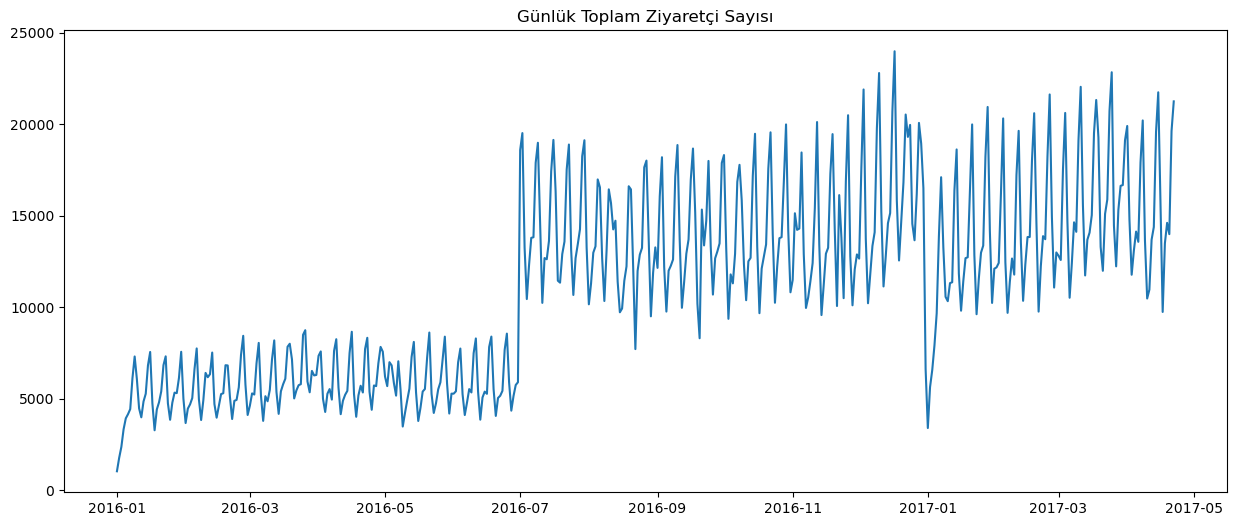

In [16]:
df_visit['visit_date'] = pd.to_datetime(df_visit['visit_date'])
daily_visitors = df_visit.groupby('visit_date')['visitors'].sum()
plt.figure(figsize=(15, 6))
plt.plot(daily_visitors)
plt.title('Günlük Toplam Ziyaretçi Sayısı')
plt.show()


## Feature Engineering & Modelleme


In [17]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_log_error
from sklearn.preprocessing import LabelEncoder

# Merge Date Info
df_date['calendar_date'] = pd.to_datetime(df_date['calendar_date'])
train = pd.merge(df_visit, df_date, left_on='visit_date', right_on='calendar_date', how='left')

# Date Features
train['year'] = train['visit_date'].dt.year
train['month'] = train['visit_date'].dt.month
train['day'] = train['visit_date'].dt.day
train['day_of_week_num'] = train['visit_date'].dt.dayofweek

# Encoding
lbl = LabelEncoder()
train['air_store_id_encoded'] = lbl.fit_transform(train['air_store_id'])

# Train/Val Split
features = ['air_store_id_encoded', 'year', 'month', 'day', 'day_of_week_num', 'holiday_flg']
target = 'visitors'
X = train[features]
y = np.log1p(train[target])

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, shuffle=False)

model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

preds = model.predict(X_val)
rmsle = np.sqrt(mean_squared_log_error(np.expm1(y_val), np.expm1(preds)))
print(f'Validation RMSLE: {rmsle:.4f}')


Validation RMSLE: 1.0360


## Model Değerlendirme Metrikleri

Modelin performansını detaylı olarak analiz ediyoruz.

In [18]:
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

y_true_orig = np.expm1(y_val)
y_pred_orig = np.expm1(preds)

r2 = r2_score(y_true_orig, y_pred_orig)
mae = mean_absolute_error(y_true_orig, y_pred_orig)
mse = mean_squared_error(y_true_orig, y_pred_orig)
rmse = np.sqrt(mse)

print(f'R2 Score: {r2:.4f}')
print(f'MAE: {mae:.4f}')
print(f'MSE: {mse:.4f}')
print(f'RMSE: {rmse:.4f}')
print(f'RMSLE: {rmsle:.4f}')

R2 Score: -0.6778
MAE: 15.1282
MSE: 418.9004
RMSE: 20.4671
RMSLE: 1.0360


## Kaggle Submission Oluşturma

Test verisi üzerinde tahminler üreterek submission dosyasını kaydediyoruz.

In [19]:
# Örnek submission dosyasını oku
sub_df = pd.read_csv('../data/sample_submission.csv')

# ID'den tarih ve store_id çıkar
sub_df['air_store_id'] = sub_df['id'].apply(lambda x: '_'.join(x.split('_')[:2]))
sub_df['visit_date'] = sub_df['id'].apply(lambda x: x.split('_')[-1])
sub_df['visit_date'] = pd.to_datetime(sub_df['visit_date'])

# Tarih özelliklerini ekle
test = pd.merge(sub_df, df_date, left_on='visit_date', right_on='calendar_date', how='left')
test['year'] = test['visit_date'].dt.year
test['month'] = test['visit_date'].dt.month
test['day'] = test['visit_date'].dt.day
test['day_of_week_num'] = test['visit_date'].dt.dayofweek

# Store ID encode (Training'deki encoder kullanılarak)
test['air_store_id_encoded'] = lbl.transform(test['air_store_id'])

# Özellik seçimi ve tahmin
X_test = test[features]
preds_test_log = model.predict(X_test)
preds_test = np.expm1(preds_test_log)

# Submission dosyasını oluştur
submission = pd.DataFrame({'id': sub_df['id'], 'visitors': preds_test})
submission.to_csv('../submission.csv', index=False)

print("submission.csv başarıyla proje ana dizinine oluşturuldu.")
submission.head()

submission.csv başarıyla proje ana dizinine oluşturuldu.


,id,visitors
0,air_00a91d42b08b08d9_2017-04-23,14.641159
1,air_00a91d42b08b08d9_2017-04-24,21.509304
2,air_00a91d42b08b08d9_2017-04-25,28.144352
3,air_00a91d42b08b08d9_2017-04-26,26.098775
4,air_00a91d42b08b08d9_2017-04-27,31.719433


In [20]:
submission.shape

(32019, 2)